In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim

from torch_geometric.utils import from_networkx, to_networkx


import pytorch_lightning as pl
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import ModelCheckpoint, Callback, TQDMProgressBar
from pytorch_lightning.loggers import WandbLogger



from typing import Callable, Optional

In [3]:
import sys
sys.path.insert(0,'..')

In [4]:
from utils.heterophilic import get_dataset, get_fixed_splits, WebKB, Actor
from project.sheaf_datamodule import SheafDataset_ForGraphs, SheafDataModule_ForGraphs
from project.sheaf_learner import coboundary_learner_on_graph_signal
from project.sheaf_diffusion import sheaf_diffusion

In [5]:
dataset = get_dataset('texas')


In [6]:
dataset.num_features

1703

In [7]:
dataset.num_classes


5

In [8]:
dataset = get_dataset('texas')
data = dataset[0]
data = get_fixed_splits(data, 'texas', 0)

In [9]:
sheaf_dm = SheafDataModule_ForGraphs(data, 200, 1)

graph = to_networkx(data)

In [11]:
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Has isolated nodes: False
Has self-loops: False
Is undirected: True


In [12]:
#     def __init__(self, graph, Nv, dv, Ne, de, alpha, beta, learning_rate, true_sheaf = None):


In [13]:
model = coboundary_learner_on_graph_signal(to_networkx(data), len(graph), 4, graph.number_of_edges(), 4, .00, .0, 0.0001,1703, 4,0.1,0.1)

In [14]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=5, verbose=False)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/root/projects/temp_checkpoints",
    filename="test-1-sheaflearn-{epoch:02d}-{val_loss:.2f}",
    save_top_k=4,
    mode="min",
)
class PrintCallbacks(Callback):
    def on_init_start(self, trainer):
        print("Starting to init trainer!")

    def on_init_end(self, trainer):
        print("Trainer is init now")

    def on_train_end(self, trainer, pl_module):
        print("Training ended")


In [15]:
wandb_logger = WandbLogger(project="sheaf_learning_coboundary_learner")

wandb: Currently logged in as: saepark. Use `wandb login --relogin` to force relogin


In [16]:
torch.cuda.is_available()

True

In [17]:
trainer = Trainer(accelerator='gpu',callbacks=[TQDMProgressBar(refresh_rate=10),PrintCallbacks(),early_stop_callback,checkpoint_callback],logger=wandb_logger,auto_lr_find=True)

Starting to init trainer!


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer is init now


In [19]:
lr_finder = trainer.tuner.lr_find(model, sheaf_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_steps=99` reached.
LR finder stopped early after 99 steps due to diverging loss.
Restoring states from the checkpoint path at /root/projects/sheaf-learn-project/notebooks/.lr_find_96d4d20b-d83f-4430-b44a-ad137946fac6.ckpt


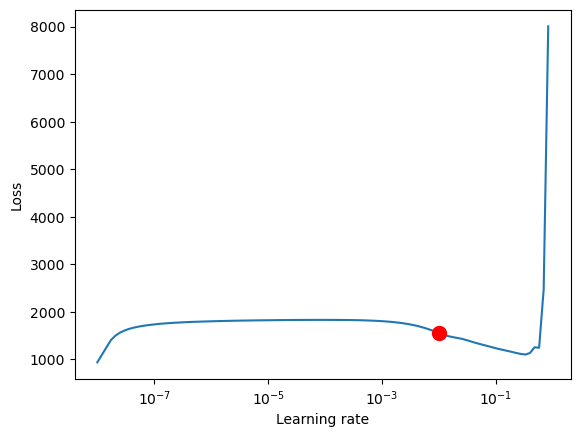

In [20]:
fig = lr_finder.plot(suggest=True)
fig.show()

In [21]:
new_lr = lr_finder.suggestion()
model.hparams.learning_rate = new_lr
model.learning_rate = new_lr

In [22]:
new_lr

0.01

In [23]:
trainer.fit(model, sheaf_dm)

/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:229: LightningDeprecationWarning: The `on_init_start` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation(
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/trainer/configuration_validator.py:233: LightningDeprecationWarning: The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.
  rank_zero_deprecation("The `on_init_end` callback hook was deprecated in v1.6 and will be removed in v1.8.")
/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /root/projects/temp_checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type          | Params
----------------------

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Training ended


In [29]:
laplacian = model.build_laplacian_from_vector().detach()

In [30]:
laplacian.requires_grad

False

In [31]:
laplacian.size()

torch.Size([732, 732])

In [32]:
def normalize_laplacian(laplacian, Nv, dv):
    diagonal_blocks = [laplacian[i*dv:(i+1)*dv, i*dv:(i+1)*dv] for i in range(Nv)]
    D = torch.block_diag(*diagonal_blocks)
    evals, evecs = torch.linalg.eig(D)
    evpow = evals**(-1/2)    
    D_pow = torch.matmul (evecs, torch.matmul (torch.diag (evpow), torch.inverse (evecs))).real
    normalized_laplacian = D_pow @ laplacian * D_pow
    return normalized_laplacian

In [33]:
normalized_laplacian = normalize_laplacian(laplacian, 183, 4)

In [34]:
normalized_laplacian

tensor([[ 1.0164e+00, -1.3622e-02, -1.9387e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.3622e-02,  1.0415e+00, -2.4082e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.9387e-03, -2.4082e-02,  1.0312e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.1676e+00,
          3.0796e-04, -8.2153e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  3.0796e-04,
          1.0175e+00, -1.7763e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -8.2153e-02,
         -1.7763e-02,  1.0998e+00]])

In [35]:
from project.sheaf_diffusion import sheaf_diffusion

In [36]:
mask = {'train_mask':data.train_mask, 
        'val_mask':data.val_mask, 
        'test_mask':data.test_mask
       }

In [37]:
normalized_laplacian.dtype

torch.float32

In [38]:
normalized_laplacian

tensor([[ 1.0164e+00, -1.3622e-02, -1.9387e-03,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.3622e-02,  1.0415e+00, -2.4082e-02,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        [-1.9387e-03, -2.4082e-02,  1.0312e+00,  ...,  0.0000e+00,
          0.0000e+00,  0.0000e+00],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  1.1676e+00,
          3.0796e-04, -8.2153e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  3.0796e-04,
          1.0175e+00, -1.7763e-02],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -8.2153e-02,
         -1.7763e-02,  1.0998e+00]])

In [39]:
#       def __init__(self, Nv, dv, Ne, de, layers, input_dim, output_dim, channels, left_weights, right_weights, sheaf_laplacian, mask, use_act, dropout, learning_rate = 0.01):



model_diffusion = sheaf_diffusion(183, 4, graph.number_of_edges(), 4, 7, 1703,5, 4, True, True, normalized_laplacian, mask, True, 0, 0.0001)

In [40]:
model_diffusion

sheaf_diffusion(
  (graph_to_sheaf): Linear(in_features=1703, out_features=16, bias=True)
  (graph_to_sheaf2): Linear(in_features=16, out_features=16, bias=True)
  (lin_left_weights): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=False)
    (1): Linear(in_features=4, out_features=4, bias=False)
    (2): Linear(in_features=4, out_features=4, bias=False)
    (3): Linear(in_features=4, out_features=4, bias=False)
    (4): Linear(in_features=4, out_features=4, bias=False)
    (5): Linear(in_features=4, out_features=4, bias=False)
    (6): Linear(in_features=4, out_features=4, bias=False)
  )
  (lin_right_weights): ModuleList(
    (0): Linear(in_features=4, out_features=4, bias=False)
    (1): Linear(in_features=4, out_features=4, bias=False)
    (2): Linear(in_features=4, out_features=4, bias=False)
    (3): Linear(in_features=4, out_features=4, bias=False)
    (4): Linear(in_features=4, out_features=4, bias=False)
    (5): Linear(in_features=4, out_features=4, bias=False

In [41]:
# Copy weights, "CRUCIAL STEP"
with torch.no_grad():
    model.graph_to_sheaf.weight.copy_(model_diffusion.graph_to_sheaf.weight)
    model.graph_to_sheaf2.weight.copy_(model_diffusion.graph_to_sheaf2.weight)
    model.graph_to_sheaf.bias.copy_(model_diffusion.graph_to_sheaf.bias)
    model.graph_to_sheaf2.bias.copy_(model_diffusion.graph_to_sheaf2.bias)
    
#Make diffusion sheaf embedding weight constant

model_diffusion.graph_to_sheaf.weight.requires_grad = False
model_diffusion.graph_to_sheaf.bias.requires_grad = False
model_diffusion.graph_to_sheaf2.weight.requires_grad = False
model_diffusion.graph_to_sheaf2.bias.requires_grad = False

In [42]:
wandb_logger_diffusion = WandbLogger(project="sheaf_learning_diffusion_with_coboundary")

/root/miniconda3/envs/sheaflearn/lib/python3.10/site-packages/pytorch_lightning/loggers/wandb.py:352: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(


In [43]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.01, patience=5, verbose=False)
checkpoint_callback = ModelCheckpoint(
    monitor="val_loss",
    dirpath="/root/projects/temp_checkpoints",
    filename="test-1-sheafdiffusion-{epoch:02d}-{val_loss:.2f}",
    save_top_k=4,
    mode="min",
)
class PrintCallbacks(Callback):
    def on_init_start(self, trainer):
        print("Starting to init trainer!")

    def on_init_end(self, trainer):
        print("Trainer is init now")

    def on_train_end(self, trainer, pl_module):
        print("Training ended")


In [44]:
lr_finder = trainer.tuner.lr_find(model_diffusion, sheaf_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_steps=100` reached.
LR finder stopped early after 1800 steps due to diverging loss.
Restoring states from the checkpoint path at /root/projects/sheaf-learn-project/notebooks/.lr_find_fa9673a7-224a-44aa-867d-e755d62f2f2d.ckpt


Failed to compute suggestion for learning rate because there are not enough points. Increase the loop iteration limits or the size of your dataset/dataloader.


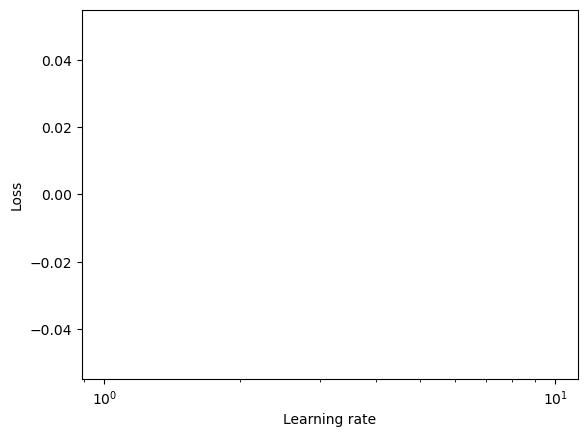

In [45]:
fig = lr_finder.plot(suggest=True)
fig.show()